In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from IPython.display import display
import base64
import string
import re
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pandas as pd

from nltk.corpus import stopwords

In [3]:
df = pd.read_csv("text_tweets_h_Uyghurs.csv")

In [ ]:
list_time = [
    ["2020-09-30", "2020-10-05"],
    ["2020-10-05", "2020-10-11"],
    ["2020-10-11", "2020-10-18"],
    ["2020-10-18", "2020-10-25"],
]

In [124]:
all_df = {}
l = 0
for starting_time, ending_time in list_time:
    all_df[l] = pd.read_csv("text_tweets_h_Uyghurs" + starting_time + "_" + ending_time + ".csv")[["text"]]
    l += 1

In [125]:
df = all_df[0]
for i in range(1,l):
    df = pd.concat([df, all_df[i]])

In [126]:
df

,text
0,The group want to raise the awareness of the t...
1,#Uyghurs prayed President Trump sign Uyghur Hu...
2,The oppression against #Uyghurs by the #Chines...
3,#Uyghurs #Uighurs #Xinjiang \n(Pls also check ...
4,World Uyghur Congress leader visits shrine hon...
...,...
447,#Uighur children orphaned by \n #Chinese...
448,#MAGA #MakeAmericaGreatAgain \nPresident Trump...
449,#VoteYourHeartForBiden because u hate #Uyghurs...
450,"If you missed the \n@ihmec\n presentation ""His..."


In [127]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [152]:
df["text_lower"] = df["text"].apply(lambda x: x.lower())
df["text_processed"] = df["text_lower"].apply(lambda x: nltk.word_tokenize(x, language='english'))
df["text_processed_is_alpha"] = df["text_processed"].apply(lambda x: [word for word in x if word.isalpha()])

df["text_tokenized_wo_stopwords"] = df["text_processed_is_alpha"].apply(lambda x: [w for w in x if not w in stop_words])

df["text_lemmatized"] = df["text_tokenized_wo_stopwords"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [22]:
import wordcloud

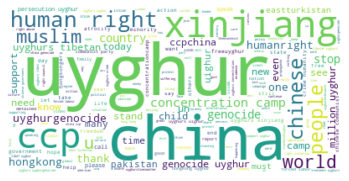

In [153]:
list_wc = []
for list_world in df["text_lemmatized"]:
    for world in list_world:
        list_wc.append(world)

wc = wordcloud.WordCloud(background_color="white", max_words=2000)
wc.generate(' '.join(list_wc))        
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

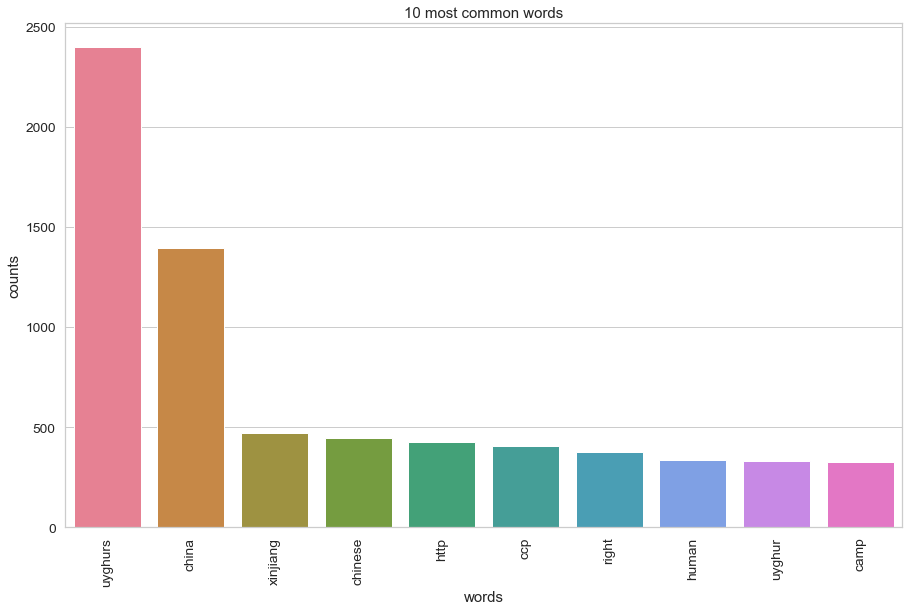

In [154]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

sns.set_style('whitegrid')
%matplotlib inline
# Helper function

def plot_10_most_common_words(count_data, count_vectorizer):

    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df["text_lemmatized"].apply(lambda x: ' '.join(x)))
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

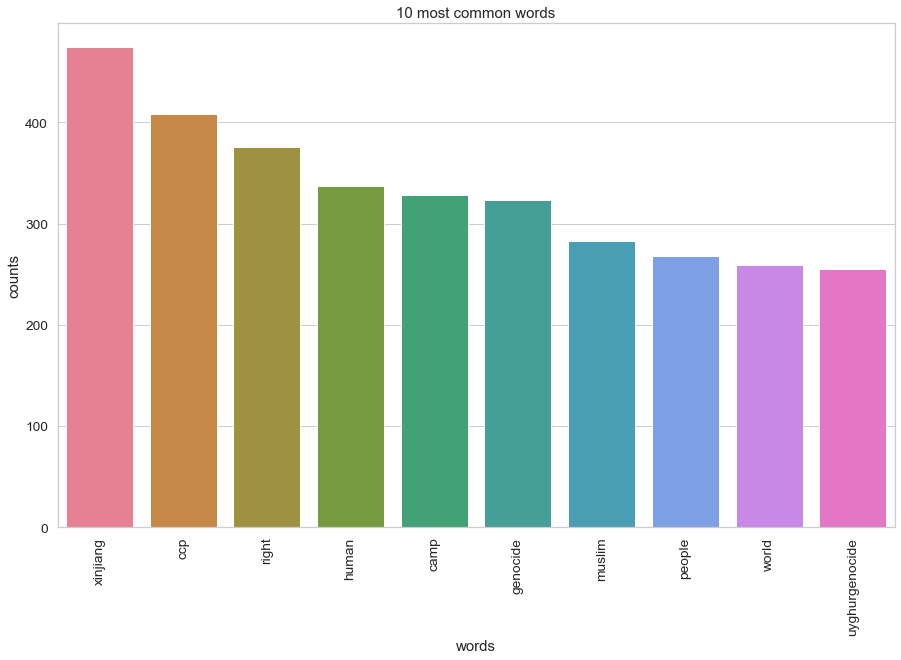

In [155]:
list_worlds_to_get_out = ["uyghurs", "china", "chinese", "http", "uyghur"]

def get_out(x):
    y = []
    for word in x:
        if not word in list_worlds_to_get_out:
            y.append(word)
    return y

df["text_lemmatized_wout_keyworlds"] = df["text_lemmatized"].apply(get_out)


# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df["text_lemmatized_wout_keyworlds"].apply(lambda x: ' '.join(x)))
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# Latent Dirichlet Allocation

In [159]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 2
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
results = lda.fit_transform(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
right xinjiang human muslim ccp genocide hongkong world country humanrights

Topic #1:
camp ccp concentration people genocide forced uyghurgenocide million xinjiang world


In [160]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))


LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

Wall time: 4min 46s


In [161]:
df["vector"] = pd.Series(list(results))

In [162]:
list_time = [
    ["2020-09-30", "2020-10-05"],
    ["2020-10-05", "2020-10-11"],
    ["2020-10-11", "2020-10-18"],
    ["2020-10-18", "2020-10-25"],
]

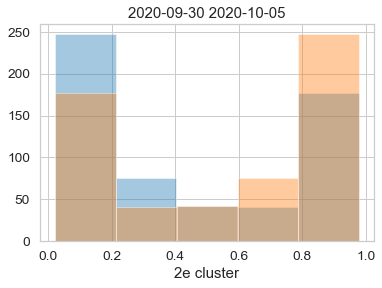

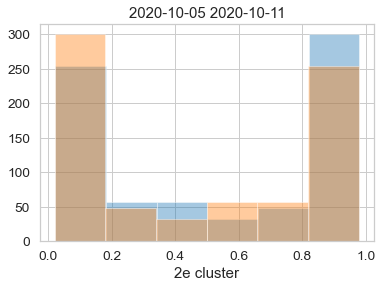

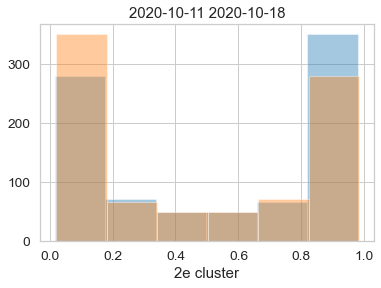

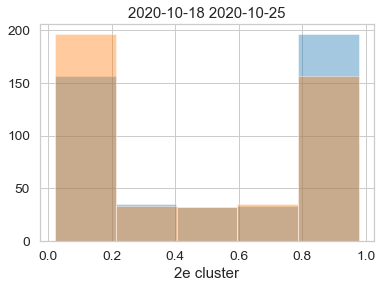

In [171]:
df_dict = {}
number = 0
for starting_time, ending_time in list_time:
    df_dict[number] =  pd.read_csv("text_tweets_h_Uyghurs" + starting_time + "_" + ending_time + ".csv")


    df_dict[number]["text_processed"] =df_dict[number]["text"].apply(lambda x: nltk.word_tokenize(x, language='english'))
    df_dict[number]["text_processed_is_alpha"] = df_dict[number]["text_processed"].apply(lambda x: [word for word in x if word.isalpha()])
    df_dict[number]["text_tokenized_wo_stopwords"] = df_dict[number]["text_processed_is_alpha"].apply(lambda x: [w for w in x if not w in stop_words])
    df_dict[number]["text_lemmatized"] = df_dict[number]["text_tokenized_wo_stopwords"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    count_data_1 = count_vectorizer.transform(df_dict[number]["text_lemmatized"].apply(lambda x: ' '.join(x)))
    df_dict[number]["score"] = pd.Series(list(lda.transform(count_data_1)))
    for i in range(number_topics):
        df_dict[number][str(i + 1) + "e cluster"] = df_dict[number]["score"].apply(lambda x: x[i])
        sns.distplot(df_dict[number][str(i+1) + "e cluster"], kde = False)
    plt.title(starting_time + " " + ending_time)
    plt.show()
    number += 1

In [168]:
for i in range(len(df_dict)):
    

4